In [ ]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 21.3 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
import torchvision


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device(torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu"))

In [ ]:
device

device(type='cuda')

In [ ]:
import torchvision
from datasets import load_dataset
from torchvision.transforms import v2

dataset = load_dataset('huggan/smithsonian_butterflies_subset', split='train')



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/609 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

HF Dataset behaves like a PyTorch Dataset (almost)

PyTorch requires a dataset to implement:

__getitem__(self, idx)

__len__(self)

HF Dataset already provides both.

In [ ]:
type(dataset), dataset

(datasets.arrow_dataset.Dataset,
 Dataset({
     features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
     num_rows: 1000
 }))

In [ ]:
dataset['image']

Column([<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x283 at 0x7B6A84358D10>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x179 at 0x7B6A84358CE0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x374 at 0x7B6A843595B0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x170 at 0x7B6A84359220>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x280 at 0x7B6A843595E0>, ...])

In [ ]:
dataset[100]

{'image_url': 'https://ids.si.edu/ids/deliveryService?id=ark:/65665/m37c28d87a790f49008699346de65652db',
 'image_alt': 'view Catasticta ludovici digital asset number 1',
 'id': 'ark:/65665/m37c28d87a790f49008699346de65652db',
 'name': 'Catasticta ludovici',
 'scientific_name': 'Catasticta ludovici',
 'gender': '1',
 'taxonomy': 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Pieridae, Pierinae',
 'region': None,
 'locality': None,
 'date': None,
 'usnm_no': 'USNMENT00804364',
 'guid': 'http://n2t.net/ark:/65665/350b4b4ca-e51f-4781-808c-5d96c2bcee1c',
 'edan_url': 'edanmdm:nmnhentomology_11217894',
 'source': 'NMNH - Entomology Dept.',
 'stage': None,
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x391>,
 'image_hash': 'a71258b7ebeff19e44fda33bb1456ee3',
 'sim_score': 0.8304916620254517}

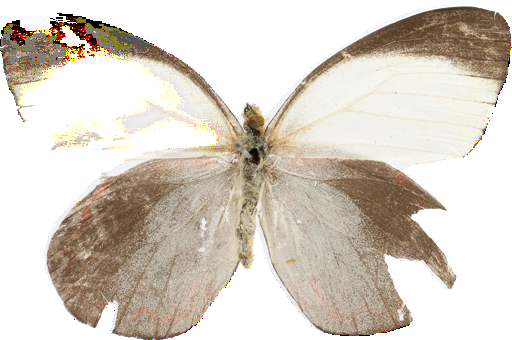

In [ ]:
img_num = dataset[909]['image']
img_num

In [ ]:
len(dataset['image']),

(1000,)

In [ ]:
df = dataset.to_pandas()
df.head(2)

,image_url,image_alt,id,name,scientific_name,gender,taxonomy,region,locality,date,usnm_no,guid,edan_url,source,stage,image,image_hash,sim_score
0,https://ids.si.edu/ids/deliveryService?id=ark:...,view Paper Kite digital asset number 1,ark:/65665/m3b302800a43ef46b8a7a87a7b1eb06ab6,Paper Kite,Idea leuconoe,None,"Animalia, Arthropoda, Hexapoda, Insecta, Lepid...","US Mid Atlantic (PA, NJ, MD, DE, DC, VA, WV)","NMNH Butterfly Pavilion, North America, United...",None,EO401041,http://n2t.net/ark:/65665/35f90bc1d-2e3c-4798-...,edanmdm:nmnheducation_11038234,Smithsonian Education and Outreach collections,NaN,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,fb0b8749d437efc70a26e54212b3572c,0.805520
1,https://ids.si.edu/ids/deliveryService?id=ark:...,view Doris Longwing digital asset number 1,ark:/65665/m351f75857f81840acb01d0eb82f2a1784,Doris Longwing,Heliconius doris,None,"Animalia, Arthropoda, Hexapoda, Insecta, Lepid...","US Mid Atlantic (PA, NJ, MD, DE, DC, VA, WV)","NMNH Insect Zoo, North America, United States,...",None,EO401027,http://n2t.net/ark:/65665/3f4d0cc10-f3b4-4323-...,edanmdm:nmnheducation_11038220,Smithsonian Education and Outreach collections,NaN,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,9657726e69494021d1c9929ee7b375fa,0.810842


In [ ]:
from datasets.features import image
image_size = 32
batch_size = 64

prepocess = v2.Compose([
    v2.Resize((image_size, image_size) , antialias=True),
    v2.RandomHorizontalFlip(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = True),
    v2.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

def transform(ex):
  images = [prepocess(img.convert('RGB')) for img in ex['image']]
  return {'images' : images}

dataset.set_transform(transform)

dataset

Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})

HF Datasets no longer returns original fields as-is. Every access to a row now runs your transform, which replaces the 'image' field with 'images'.

so `dataset['image']` won't work anymore

instead:

In [ ]:
dataset[2]

{'images': Image([[[ 0.4431, -0.0275, -0.0039,  ..., -0.4510, -0.4118,  0.0353],
         [-0.4902, -0.3882, -0.5137,  ..., -0.6235, -0.3882, -0.6392],
         [-0.5216, -0.4745, -0.5216,  ..., -0.5451, -0.4039, -0.6000],
         ...,
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],
 
        [[ 0.4196, -0.0824, -0.0588,  ..., -0.5137, -0.4588, -0.0039],
         [-0.5529, -0.4667, -0.5922,  ..., -0.6863, -0.4588, -0.6863],
         [-0.5765, -0.5529, -0.5922,  ..., -0.6078, -0.4745, -0.6471],
         ...,
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],
 
        [[ 0.3725, -0.1294, -0.1059,  ..., -0.5765, -0.5216, -0.0431],
         [-0.6157, -0.5922, -0.70

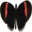

In [ ]:

img = dataset[3]['images']

show_images(img)

In [ ]:
#now creating dataloader

from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    dataset = dataset,
    batch_size= batch_size,
    shuffle = True
)

train_dataloader

In [ ]:
img_batch = next(iter(train_dataloader))
img_batch

{'images': tensor([[[[ 1.0000,  0.9922,  1.0000,  ...,  0.5451,  0.4902,  0.6392],
           [ 0.5922,  0.5294,  0.7020,  ...,  0.1216,  0.2314,  0.6706],
           [ 0.4118,  0.0510,  0.0745,  ...,  0.2157,  0.3725,  0.8118],
           ...,
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],
 
          [[ 1.0000,  0.9922,  1.0000,  ...,  0.4196,  0.2706,  0.4824],
           [ 0.4353,  0.3804,  0.6471,  ..., -0.1608, -0.1216,  0.4510],
           [ 0.0902, -0.2549, -0.1608,  ..., -0.0745,  0.0275,  0.6627],
           ...,
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],
 
          [[ 0.9922,  0.9922,  0.9922,  ...,  0.1922,  0.0039,  0.2235],
   

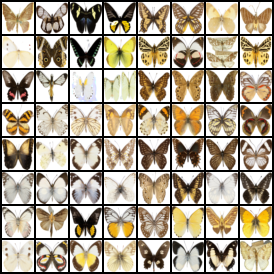

In [ ]:
show_images(img_batch['images'])

In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise_scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.36.0",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

In [ ]:

noise_scheduler.alphas_cumprod[:5]

tensor([0.9999, 0.9998, 0.9996, 0.9995, 0.9993])

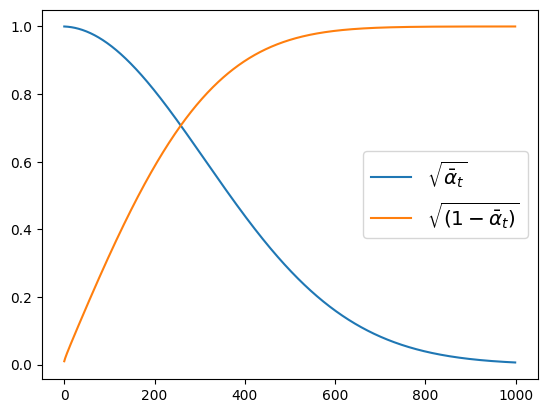

In [ ]:
import matplotlib.pyplot as plt


plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")



Noisy X shape torch.Size([8, 3, 32, 32])


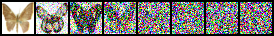

In [ ]:
timesteps = torch.linspace(0, 999, 8).long().to(device)

img_xb = img_batch['images'][:8]

noise = torch.randn_like(img_xb) # Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1.

noisy_xb = noise_scheduler.add_noise(img_xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb)

In [ ]:
img_xb.shape, timesteps

(torch.Size([8, 3, 32, 32]),
 tensor([  0, 142, 285, 428, 570, 713, 856, 999], device='cuda:0'))

In [ ]:
img_xb.shape[0]

8

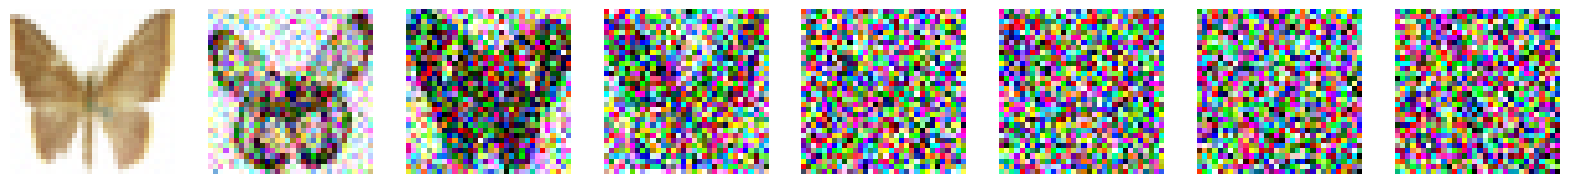

In [ ]:
#just visualizing big


import matplotlib.pyplot as plt
import torch

# Convert to [0,1] for visualization
images_to_plot = (noisy_xb.clamp(-1, 1) + 1) / 2  # now in [0,1]

# Move to CPU and convert to NumPy
images_to_plot = images_to_plot.cpu().permute(0, 2, 3, 1).numpy()  # [B,H,W,C]

# Plot each image big
fig, axes = plt.subplots(1, len(images_to_plot), figsize=(20,5))  # wide figure
for ax, img in zip(axes, images_to_plot):
    ax.imshow(img)
    ax.axis('off')
plt.show()


In [ ]:
dd = torch.randint(0,10,size=(2,3,2))
dd

tensor([[[2, 5],
         [8, 9],
         [3, 9]],

        [[5, 4],
         [5, 3],
         [4, 4]]])

In [ ]:
from diffusers import StableDiffusionPipeline

model_id = 'sd-dreambooth-library/mr-potato-head'

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype = torch.float16).to(device)


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


model_index.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

safety_checker/pytorch_model.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/589 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/597 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--sd-dreambooth-library--mr-potato-head/snapshots/34246b94acd8b96166e8d93eaded001c380a2d4e/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--sd-dreambooth-library--mr-potato-head/snapshots/34246b94acd8b96166e8d93eaded001c380a2d4e/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
`torch_dtype` is deprecated! Use `dtype` instead!
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--sd-dreambooth-library--mr-potato-head/snapshots/34246b94acd8b96166e8d93eaded001c380a2d4e/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--sd-dreambooth-library--mr-potato-head/snapshots/34246b94acd8b96166e8d93eaded001c380a2d4e/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


It’s a pipeline composed of multiple models packaged together:

Stable Diffusion is not a single neural network.
It’s a pipeline composed of multiple models packaged together:

A text encoder (CLIP)

A UNet (denoising model)

A VAE (encoder/decoder)

A scheduler

Safety checker (optional)

So when you do:

pipe = StableDiffusionPipeline.from_pretrained(model_id)


you’re loading an entire multi-part generative system, not a single network.

In contrast, something like:

```resnet = torchvision.models.resnet50(pretrained=True)```


loads one straightforward CNN used for classification.

In [ ]:
pipe

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.36.0",
  "_name_or_path": "sd-dreambooth-library/mr-potato-head",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

pipe1 = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size = image_size, #32
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels = (64,128,128,256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D"
    ),
    up_block_types = (
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    )
)


model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64, 64, ker

In [ ]:
len(train_dataloader)

16

In [ ]:
# timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()
timesteps

tensor([ 315,    7,  104, 1211, 1496,  472,  721, 1629,  291, 1284, 1826, 1416,
         285, 1680,  907,  992, 1174, 1231, 1125, 1970,  490,  700,  295,  894,
        1853,  878, 1979,  710,  545, 1340,  516, 1487, 1741, 1578,  869, 1542,
        1983,   88,  389, 1618], device='cuda:0')

In [ ]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=2000, beta_schedule="squaredcos_cap_v2")

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0] #64

        # Sample a random timestep for each image
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")
        print(f'DD: {loss.item()}')

Epoch:5, loss: 0.07599228410981596
DD: 0.10056295245885849
Epoch:10, loss: 0.06643817713484168
DD: 0.059786900877952576
Epoch:15, loss: 0.05867130751721561
DD: 0.09479713439941406
Epoch:20, loss: 0.061574684688821435
DD: 0.09434295445680618
Epoch:25, loss: 0.05738665163516998
DD: 0.062282588332891464
Epoch:30, loss: 0.05471079214476049
DD: 0.06563152372837067


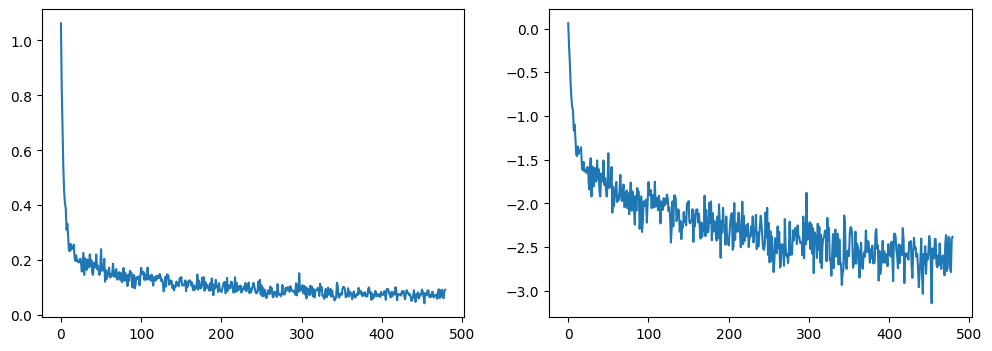

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].plot(losses)
axes[1].plot(np.log(losses))#log for better visualization
plt.show()

In [ ]:
noise_scheduler.timesteps

tensor([1998, 1996, 1994, 1992, 1990, 1988, 1986, 1984, 1982, 1980, 1978, 1976,
        1974, 1972, 1970, 1968, 1966, 1964, 1962, 1960, 1958, 1956, 1954, 1952,
        1950, 1948, 1946, 1944, 1942, 1940, 1938, 1936, 1934, 1932, 1930, 1928,
        1926, 1924, 1922, 1920, 1918, 1916, 1914, 1912, 1910, 1908, 1906, 1904,
        1902, 1900, 1898, 1896, 1894, 1892, 1890, 1888, 1886, 1884, 1882, 1880,
        1878, 1876, 1874, 1872, 1870, 1868, 1866, 1864, 1862, 1860, 1858, 1856,
        1854, 1852, 1850, 1848, 1846, 1844, 1842, 1840, 1838, 1836, 1834, 1832,
        1830, 1828, 1826, 1824, 1822, 1820, 1818, 1816, 1814, 1812, 1810, 1808,
        1806, 1804, 1802, 1800, 1798, 1796, 1794, 1792, 1790, 1788, 1786, 1784,
        1782, 1780, 1778, 1776, 1774, 1772, 1770, 1768, 1766, 1764, 1762, 1760,
        1758, 1756, 1754, 1752, 1750, 1748, 1746, 1744, 1742, 1740, 1738, 1736,
        1734, 1732, 1730, 1728, 1726, 1724, 1722, 1720, 1718, 1716, 1714, 1712,
        1710, 1708, 1706, 1704, 1702, 17

In [ ]:
import torch
from tqdm.auto import tqdm
device = "cuda"

scheduler = noise_scheduler
unet = model

num_steps = 1000
scheduler.set_timesteps(num_steps)

# Fix seed so the trajectory is deterministic
generator = torch.Generator(device=device).manual_seed(42)

# Initial noise = x_T
sample = torch.randn(
    (1, unet.config.in_channels,
     unet.config.sample_size,
     unet.config.sample_size),
    generator=generator,
    device=device,
)

saved_images = {}

for step, t in tqdm(enumerate(scheduler.timesteps),):
    with torch.no_grad():
        model_output = unet(sample, t).sample
        sample = scheduler.step(model_output, t, sample).prev_sample

    if step in {50, 200, 800, 999}:
        img = (sample / 2 + 0.5).clamp(0, 1)
        saved_images[step] = img.detach().cpu()


0it [00:00, ?it/s]

In [ ]:
unet.config

FrozenDict([('sample_size', 32),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('time_embedding_dim', None),
            ('freq_shift', 0),
            ('flip_sin_to_cos', True),
            ('down_block_types',
             ('DownBlock2D',
              'DownBlock2D',
              'AttnDownBlock2D',
              'AttnDownBlock2D')),
            ('mid_block_type', 'UNetMidBlock2D'),
            ('up_block_types',
             ('AttnUpBlock2D', 'AttnUpBlock2D', 'UpBlock2D', 'UpBlock2D')),
            ('block_out_channels', (64, 128, 128, 256)),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 1),
            ('downsample_type', 'conv'),
            ('upsample_type', 'conv'),
            ('dropout', 0.0),
            ('act_fn', 'silu'),
            ('attention_head_dim', 8),
            ('norm_num

In [ ]:
saved_images[50].shape

torch.Size([1, 3, 32, 32])

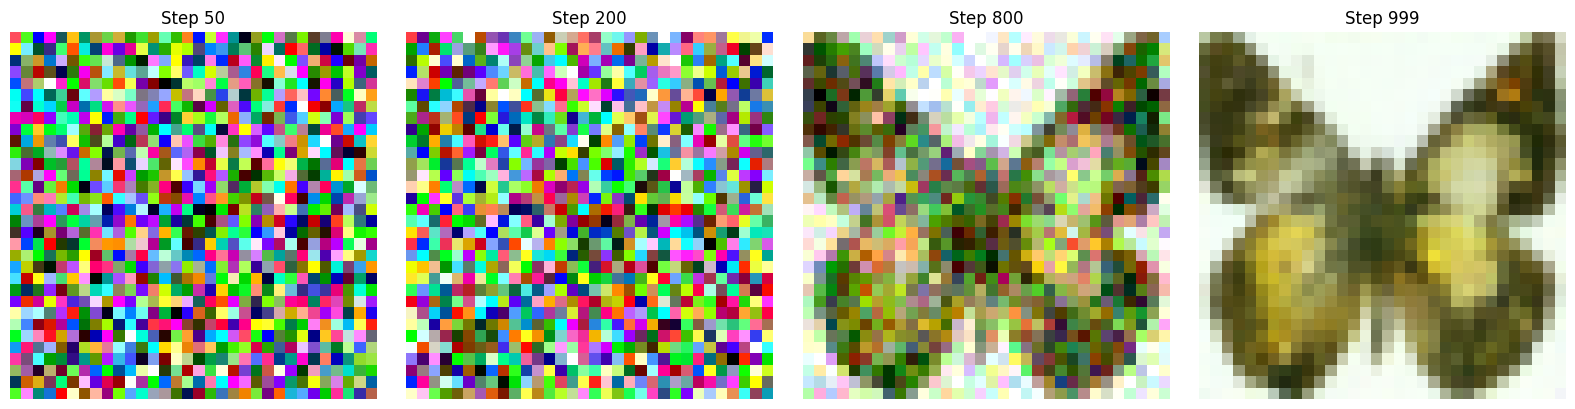

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def tensor_to_img(x):
    # x: (1, C, H, W)
    x = x.squeeze(0)           # (C, H, W)
    x = x.permute(1, 2, 0)     # (H, W, C)
    return x.numpy()


steps = sorted(saved_images.keys())

fig, axes = plt.subplots(1, len(steps), figsize=(4 * len(steps), 4))

if len(steps) == 1:
    axes = [axes]

for ax, step in zip(axes, steps):
    img = tensor_to_img(saved_images[step])
    ax.imshow(img)
    ax.set_title(f"Step {step}")
    ax.axis("off")

plt.tight_layout()
plt.show()


  0%|          | 0/2000 [00:00<?, ?it/s]

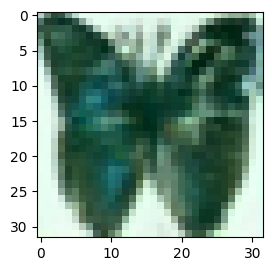

In [ ]:
##Generate image from the trained model

from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler,)

pipeline_output = image_pipe(num_inference_steps=2000, batch_size=2, )#batch size 2 means there will be 2 image generated

pipeline_output.images[0]
plt.subplot(1,2,1
plt.imshow(pipeline_output.images[0])


In [ ]:
#save the pipeline

image_pipe.save_pretrained('my_butterfly_pipeline')

In [ ]:
!ls my_butterfly_pipeline/unet


config.json  diffusion_pytorch_model.safetensors


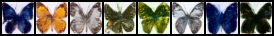

In [ ]:
# Random starting point (8 random images):
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

In [ ]:
sample = torch.randn(8, 3, 32, 32).to(device)

some_steps = [500, 700, 800, 999, 1500, 1800, 1999]
step_imgs = []

for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

  with torch.inference_mode():
    residual = model(sample, t).sample

  sample = noise_scheduler.step(residual, t, sample).prev_sample

  if i in some_steps:
    print(type(residual), residual.shape)
    step_imgs.append(sample)


0it [00:00, ?it/s]

<class 'torch.Tensor'> torch.Size([8, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([8, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([8, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([8, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([8, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([8, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([8, 3, 32, 32])


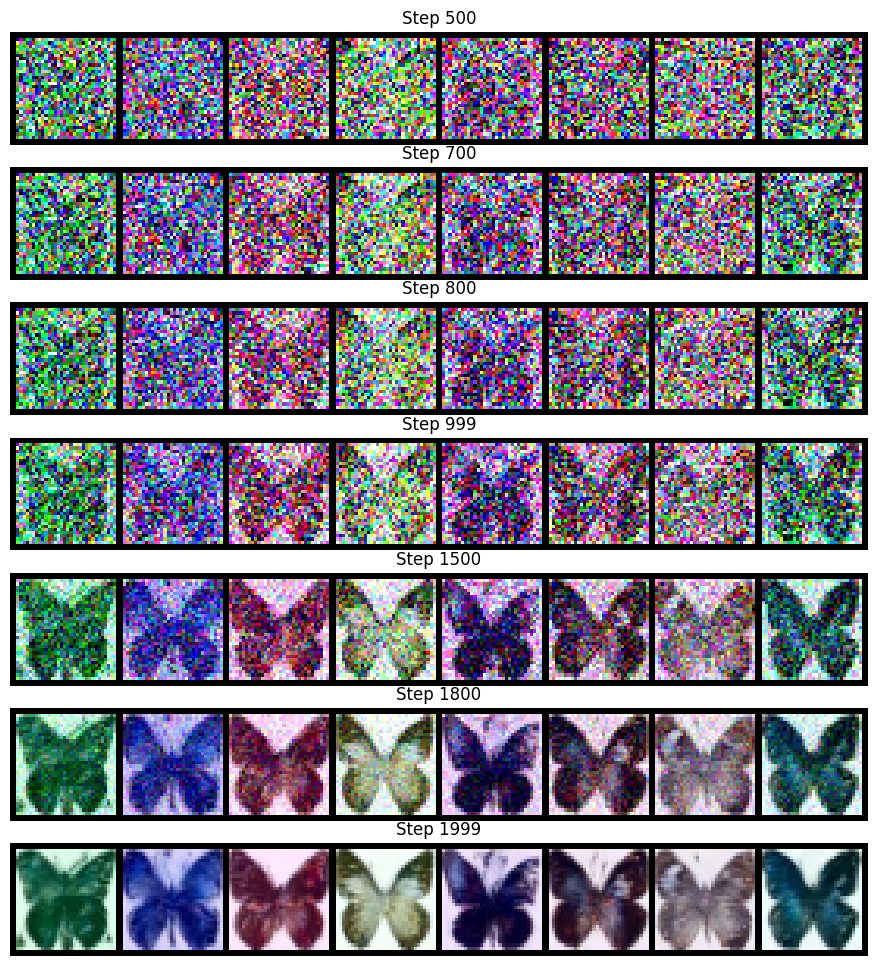

In [ ]:
fig , axes = plt.subplots( len(step_imgs),1, figsize=(4*len(step_imgs),12))
scheduler = image_pipe.scheduler

for ax, img, step in zip(axes, step_imgs,some_steps):
  grid = show_images(img)
  t = scheduler.timesteps[step]
  alpha_bar = scheduler.alphas_cumprod[t].item()

  ax.imshow(grid)
  ax.axis('off')
  ax.set_title(f'Step {step} || ᾱₜ={alpha_bar:.3f}')


In [ ]:
#load the model from disk
img_pipe = DDPMPipeline.from_pretrained('my_butterfly_pipeline').to(device)

img_pipe.scheduler




Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.36.0",
  "beta_end": 0.02,
  "beta_schedule": "squaredcos_cap_v2",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 2000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

In [ ]:
img_pipe.scheduler.config

FrozenDict([('num_train_timesteps', 2000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'squaredcos_cap_v2'),
            ('trained_betas', None),
            ('variance_type', 'fixed_small'),
            ('clip_sample', True),
            ('prediction_type', 'epsilon'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('clip_sample_range', 1.0),
            ('sample_max_value', 1.0),
            ('timestep_spacing', 'leading'),
            ('steps_offset', 0),
            ('rescale_betas_zero_snr', False),
            ('_class_name', 'DDPMScheduler'),
            ('_diffusers_version', '0.36.0')])

In [ ]:
img_pipe.unet.config

FrozenDict([('sample_size', 32),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('time_embedding_dim', None),
            ('freq_shift', 0),
            ('flip_sin_to_cos', True),
            ('down_block_types',
             ['DownBlock2D',
              'DownBlock2D',
              'AttnDownBlock2D',
              'AttnDownBlock2D']),
            ('mid_block_type', 'UNetMidBlock2D'),
            ('up_block_types',
             ['AttnUpBlock2D', 'AttnUpBlock2D', 'UpBlock2D', 'UpBlock2D']),
            ('block_out_channels', [64, 128, 128, 256]),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 1),
            ('downsample_type', 'conv'),
            ('upsample_type', 'conv'),
            ('dropout', 0.0),
            ('act_fn', 'silu'),
            ('attention_head_dim', 8),
            ('norm_num

  0%|          | 0/2000 [00:00<?, ?it/s]

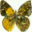

In [ ]:
output = img_pipe(
    batch_size = 2,
    num_inference_steps = img_pipe.scheduler.config.num_train_timesteps
)



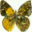

In [ ]:
output.images[0]


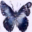

In [ ]:
output.images[1]

In [ ]:
#for more faster
from diffusers import DDIMScheduler

# Replace the scheduler (keeps the same config, including num_train_timesteps)
image_pipe.scheduler = DDIMScheduler.from_config(img_pipe.scheduler.config)

# Now generate with fewer steps
pipeline_output = image_pipe(
    batch_size=2,
    num_inference_steps=50,  # Much faster, great results!
    generator=torch.Generator("cuda").manual_seed(42)
)

  0%|          | 0/50 [00:00<?, ?it/s]

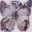

In [ ]:
pipeline_output.images[0]

In [ ]:
from huggingface_hub import get_full_repo_name

model_name = 'jomjom-butterfly-model'

hub_model_id = get_full_repo_name(model_name)

hub_model_id

'abcd2019/jomjom-butterfly-model'

In [ ]:
from huggingface_hub import HfApi, create_repo
create_repo(hub_model_id)

api = HfApi()
api.upload_folder(
    folder_path = 'my_butterfly_pipeline/scheduler',
    path_in_repo= '',
    repo_id = hub_model_id
)


api.upload_folder(
    folder_path = 'my_butterfly_pipeline/unet',
    path_in_repo = '',
    repo_id = hub_model_id
)

api.upload_file(
    path_or_fileobj = 'my_butterfly_pipeline/model_index.json',
    path_in_repo = 'model_index.json',
    repo_id = hub_model_id
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...pytorch_model.safetensors:   2%|1         | 1.13MB / 74.2MB            

CommitInfo(commit_url='https://huggingface.co/abcd2019/jomjom-butterfly-model/commit/715191ff040844460d2b0cd9cb4c825aa0670db4', commit_message='Upload model_index.json with huggingface_hub', commit_description='', oid='715191ff040844460d2b0cd9cb4c825aa0670db4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/abcd2019/jomjom-butterfly-model', endpoint='https://huggingface.co', repo_type='model', repo_id='abcd2019/jomjom-butterfly-model'), pr_revision=None, pr_num=None)

In [ ]:
from huggingface_hub import ModelCard

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for Unit 1 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of cute 🦋.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image

"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)



CommitInfo(commit_url='https://huggingface.co/abcd2019/jomjom-butterfly-model/commit/58c7c0beebdead8fa3a39529292c09c2f1598d70', commit_message='Upload README.md with huggingface_hub', commit_description='', oid='58c7c0beebdead8fa3a39529292c09c2f1598d70', pr_url=None, repo_url=RepoUrl('https://huggingface.co/abcd2019/jomjom-butterfly-model', endpoint='https://huggingface.co', repo_type='model', repo_id='abcd2019/jomjom-butterfly-model'), pr_revision=None, pr_num=None)

In [ ]:
import torch
from diffusers import DiffusionPipeline

# switch to "mps" for apple devices
pipe = DiffusionPipeline.from_pretrained("abcd2019/jomjom-butterfly-model", dtype=torch.bfloat16, device_map="cuda")

image = pipe().images[0]

Keyword arguments {'dtype': torch.bfloat16} are not expected by DDPMPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

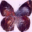

In [ ]:
image
